# Read in packages

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt

# Read in Seattle data

In [2]:
seattle_cal_df = pd.read_csv('data/seattle/calendar.csv',parse_dates=True)
seattle_listings_df = pd.read_csv('data/seattle/listings.csv',parse_dates=True)
seattle_reviews_df = pd.read_csv('data/seattle/reviews.csv')

### Lets have a quick look at the data types to make sure that they are in the correct format

In [3]:
seattle_cal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


#### So we can see that we need to adjust the date and price collumns because they are not date time objects

In [4]:
#Convert the date column to a date time type
seattle_cal_df['new_date'] = pd.to_datetime(seattle_cal_df['date']).dt.normalize()

seattle_cal_df = seattle_cal_df.drop('date', axis = 1)

In [5]:
seattle_cal_df[['new_date']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 1 columns):
new_date    1393570 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 10.6 MB


#### Now lets remove the $ from the Price column and convert it to a numerical data type

In [6]:
#Remove $ from strings

seattle_cal_df['price'].replace(regex=True,inplace=True,to_replace=r'\$',value=r'')
seattle_cal_df['price'].replace(regex=True,inplace=True,to_replace=r'\,',value=r'')

#convert price column to a float type
seattle_cal_df['new_price'] = pd.to_numeric(seattle_cal_df['price'])

seattle_cal_df = seattle_cal_df.drop('price', axis = 1)

In [7]:
seattle_cal_df[['new_price']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 1 columns):
new_price    934542 non-null float64
dtypes: float64(1)
memory usage: 10.6 MB


In [8]:
print('The calendar data contains', len(seattle_cal_df.columns.tolist()), 
      'columns. The are called')

for col in seattle_cal_df.columns.tolist():
          print(col)

The calendar data contains 4 columns. The are called
listing_id
available
new_date
new_price


#### Lets see if there are any missing values

In [9]:
seattle_cal_df.isna().sum()

listing_id         0
available          0
new_date           0
new_price     459028
dtype: int64

#### what is that as a fraction of the total data set? 

In [10]:
missing_prices = round((len(
    seattle_cal_df['new_price'][seattle_cal_df['new_price'].isnull()])/len(seattle_cal_df['new_price'])*100
                       ),2)

unique_listings = len(seattle_cal_df['listing_id'].unique())

early = min(seattle_cal_df['new_date'])
late = max(seattle_cal_df['new_date'])

print('From the above we can see that there are', 
      unique_listings, 'unique listings.\n', 
      missing_prices,'% of the pices are missing too.\n',
     'This data ranges from', early, 'to', late)

From the above we can see that there are 3818 unique listings.
 32.94 % of the pices are missing too.
 This data ranges from 2016-01-04 00:00:00 to 2017-01-02 00:00:00


#### Are properties that have these missing values available?

In [11]:
price_null = seattle_cal_df[['listing_id',
                            'new_date',
                            'available',
                            'new_price']][seattle_cal_df['new_price'].isnull()]


price_not_null = seattle_cal_df[['listing_id',
                                'new_date',
                                'available',
                                'new_price']][seattle_cal_df['new_price'].notnull()]

#### From the above two cells it seems that when the price is null, the availibility column is f. When the price is not null the availability is t. 

#### This would seem to sugest that t stands for',true and f stands for false. Now I will replace t with 1 and f with 0.

In [12]:
old_avail = seattle_cal_df[['available']]
seattle_cal_df['new_available'] = old_avail.replace(['f','t'],[0,1])
seattle_cal_df = seattle_cal_df.drop('available', axis =1)

# What is the distribution of prices?

In [13]:
date_price_df = seattle_cal_df[[
    'new_date',
    'new_price']].groupby([
    'new_date']).mean().reset_index(level=['new_date'])

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


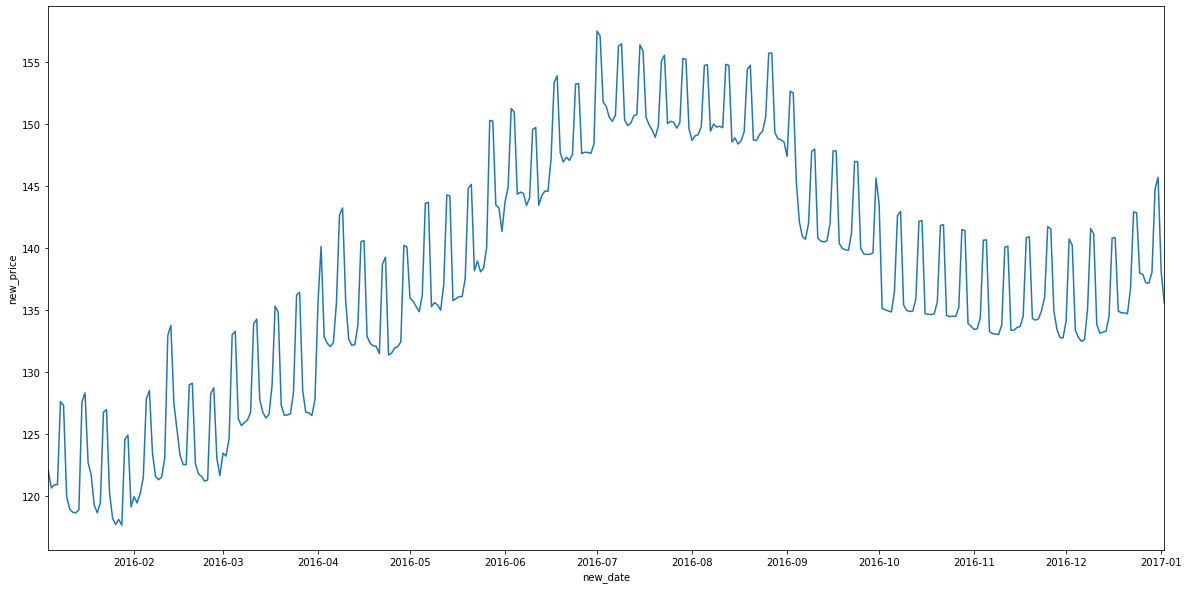

In [14]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.lineplot(x='new_date', y='new_price', data=date_price_df)
ax.set(xlim = ('2016-01-04', '2017-01-02'));

### We can see here that there is a significant increase in prices during the spring and summer times April - September and the winter months February - March are significantlt less.

# How do prices vary by day of the week?

In [15]:

round(date_price_df.groupby(date_price_df['new_date'].dt.weekday_name).mean().sort_values(by = 'new_price'),2)

,new_price
new_date,
Tuesday,135.38
Wednesday,135.41
Monday,135.64
Thursday,136.38
Sunday,136.46
Friday,142.96
Saturday,143.12


###  we see here the increase for weekends are frday and saturday compared to monday - thursday

# How many of each property type are there?

In [16]:
prop_type_df = seattle_listings_df['property_type'].value_counts()
prop_type_df

House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Camper/RV            13
Bungalow             13
Boat                  8
Tent                  5
Treehouse             3
Chalet                2
Dorm                  2
Yurt                  1
Name: property_type, dtype: int64

In [19]:
round(seattle_listings_df['review_scores_value'][seattle_listings_df['review_scores_value'].notnull()].value_counts(normalize=True)*100,1)

10.0    56.1
9.0     36.0
8.0      6.0
7.0      1.2
6.0      0.5
4.0      0.1
5.0      0.0
2.0      0.0
Name: review_scores_value, dtype: float64

### over 90% of reviews are 9 to 10